In [1]:
# Deep Learning Fundamentals: MNIST Case Study
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from time import time
from collections import defaultdict
from torchvision import models
from torchvision import transforms
from torch.cuda.amp import GradScaler, autocast

### Data Collection

In [2]:
import requests

# URLs of the files
data_train_features_url = 'https://www.raphaelcousin.com/modules/module8/exercise/X_train.pth'
data_train_labels_url = 'https://www.raphaelcousin.com/modules/module8/exercise/y_train.pth'
data_test_features_url = 'https://www.raphaelcousin.com/modules/module8/exercise/X_test.pth'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(data_train_features_url, 'X_train.pth')
download_file(data_train_labels_url, 'y_train.pth')
download_file(data_test_features_url, 'X_test.pth')

Downloaded X_train.pth from https://www.raphaelcousin.com/modules/module8/exercise/X_train.pth
Downloaded y_train.pth from https://www.raphaelcousin.com/modules/module8/exercise/y_train.pth
Downloaded X_test.pth from https://www.raphaelcousin.com/modules/module8/exercise/X_test.pth


In [3]:
import torch

# Load the saved tensors
X = torch.load('X_train.pth')
y = torch.load('y_train.pth')

# Print shapes to verify the data
print("Dataset shapes:")
print(f"X_train: {X.shape}")  # Should be torch.Size([50000, 28, 28])
print(f"y_train: {y.shape}")  # Should be torch.Size([50000])

# Example: access the first image and its label
first_image = X[0]
first_label = y[0]

print(f"\nFirst image shape: {first_image.shape}")  # Should be torch.Size([3, 32, 32])
print(f"First image label: {first_label}")         # Should be a number between 0-9

C:\Users\Neroued\AppData\Local\Temp\ipykernel_32804\397282496.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load('X_train.pth')


Dataset shapes:
X_train: torch.Size([50000, 3, 32, 32])
y_train: torch.Size([50000])

First image shape: torch.Size([3, 32, 32])
First image label: 6


C:\Users\Neroued\AppData\Local\Temp\ipykernel_32804\397282496.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y = torch.load('y_train.pth')


### Data Analysis

In [4]:
X.shape

torch.Size([50000, 3, 32, 32])

In [5]:
y.shape

torch.Size([50000])

In [6]:
def plot_images(X, y, num_examples=5, figsize=(15, 3)):
    # Create figure
    fig, axes = plt.subplots(1, num_examples, figsize=figsize)
    
    # Ensure axes is always a numpy array
    if num_examples == 1:
        axes = np.array([axes])
    
    # Plot each example
    for i in range(num_examples):
        # Get the image
        img = np.array(X[i]).astype(int)
        
        # If the image has 3 dimensions, transpose it to (height, width, channels)
        if img.ndim == 3 and img.shape[0] == 3:  # Shape is (3, height, width)
            img = np.transpose(img, (1, 2, 0))  # Convert to (height, width, channels)
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {y[i]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    return fig

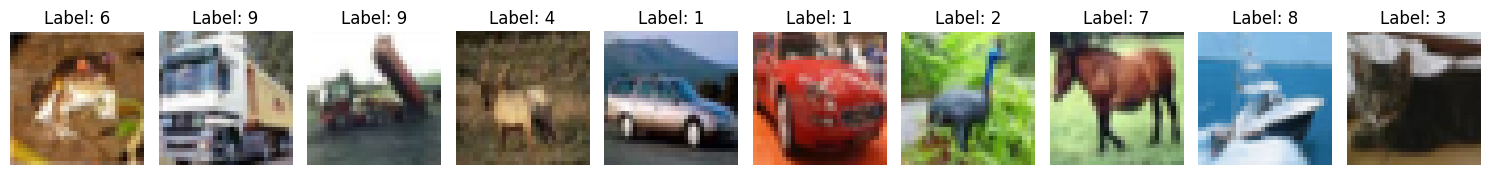

In [7]:
# Plot some examples
fig = plot_images(X, y, num_examples=10)
plt.show()

### Data Preprocessing
Scale, split the data and create dataLoaders

In [8]:
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
def preprocess_data(X, y, batch_size=32, train_size=0.7, val_size=0.15, random_state=42):
    # Scale features
    num_samples, channels, height, width = X.shape
    X_reshaped = X.reshape(num_samples, -1)  # Flatten for scaling
    scaler = StandardScaler()
    X_scaled_flat = scaler.fit_transform(X_reshaped)  # Scale features
    X_scaled = X_scaled_flat.reshape(num_samples, channels, height, width)  # Reshape with channel dimension
    
    # Split data into train+val and test
    test_size = 1 - train_size - val_size
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_scaled, y, test_size=test_size, 
        random_state=random_state, stratify=y
    )
    
    # Split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, 
        test_size=val_size/(train_size + val_size),
        random_state=random_state, stratify=y_trainval
    )
    
    # Convert to tensors and create dataloaders
    
    data_loader_train= DataLoader(
        TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)),
        batch_size=batch_size, shuffle=True
    )
    
    data_loader_val= DataLoader(
        TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)),
        batch_size=batch_size
    )
    
    data_loader_test= DataLoader(
        TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)),
        batch_size=batch_size
    )
    
    return data_loader_train, data_loader_val, data_loader_test, scaler

In [10]:
train_loader, val_loader, test_loader, train_scaler = preprocess_data(X, y)

### Model
Create a simple model with right input output and define criterion and criterion/loss

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        # Input shape: [batch, 3, 28, 28]
        x = self.conv1(x)        # -> [batch, 32, 14, 14]
        x = self.conv2(x)        # -> [batch, 64, 7, 7]
        x = self.conv3(x)        # -> [batch, 128, 3, 3]
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc(x)          # -> [batch, 10]
        return x

In [12]:
def create_model(device):
    # Create model instance
    model = ConvNet().to(device)
    
    # Define loss function
    criterion = nn.CrossEntropyLoss().to(device)
    
    # Define optimizer with improved parameters
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )
    
    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True,
        min_lr=1e-6
    )
    return model, criterion, optimizer, scheduler

### Train
Create a loop to train your model

In [13]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [14]:
def train_epoch(model, loader, criterion, optimizer, device, is_training=True):
    """Run one epoch of training or validation."""
    model.train() if is_training else model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    context = torch.enable_grad() if is_training else torch.no_grad()
    with context:
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            if is_training:
                optimizer.zero_grad()
                
            output = model(data)
            loss = criterion(output, target)
            
            if is_training:
                loss.backward()
                optimizer.step()
            
            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, num_epochs=10, patience=7, checkpoint_path='best_model.pt'):
    early_stopping = EarlyStopping(patience=patience, path=checkpoint_path)
    history = defaultdict(list)
    best_acc = 0.0
    start_time = time()
    
    print("Training started...")
    for epoch in range(num_epochs):
        epoch_start = time()
        
        # Training phase
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, is_training=True
        )
        
        # Validation phase
        val_loss, val_acc = train_epoch(
            model, val_loader, criterion, optimizer, device, is_training=False
        )

        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Print epoch results
        print(f"\nEpoch {epoch+1}/{num_epochs} - Time: {time() - epoch_start:.2f}s")
        print(f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 60)
        
        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
            }, 'best_acc_model.pt')
    
    total_time = time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best validation accuracy: {best_acc:.2f}%")
    return history

In [16]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model and training components
model, criterion, optimizer, scheduler = create_model(device)

test_loss, test_acc = train_epoch(
    model, test_loader, criterion, optimizer, device, is_training=False
)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

c:\Users\Neroued\.conda\envs\MPI\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Test Loss: 2.3037 - Test Acc: 9.57%


In [18]:
# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    num_epochs=100,
    patience=15
)

Training started...

Epoch 1/100 - Time: 3.90s
Train Loss: 1.1339 - Train Acc: 60.28%
Val Loss: 1.0800 - Val Acc: 61.61%
Learning Rate: 0.001000
------------------------------------------------------------
Validation loss decreased (inf --> 1.079989). Saving model ...

Epoch 2/100 - Time: 3.69s
Train Loss: 1.0889 - Train Acc: 61.97%
Val Loss: 0.8521 - Val Acc: 70.40%
Learning Rate: 0.001000
------------------------------------------------------------
Validation loss decreased (1.079989 --> 0.852085). Saving model ...

Epoch 3/100 - Time: 3.71s
Train Loss: 1.0216 - Train Acc: 63.88%
Val Loss: 0.8123 - Val Acc: 72.12%
Learning Rate: 0.001000
------------------------------------------------------------
Validation loss decreased (0.852085 --> 0.812342). Saving model ...

Epoch 4/100 - Time: 3.70s
Train Loss: 0.9632 - Train Acc: 65.85%
Val Loss: 0.7907 - Val Acc: 72.28%
Learning Rate: 0.001000
------------------------------------------------------------
Validation loss decreased (0.812342 -

In [19]:
def plot_training_history(history):
    """
    Plot training history
    
    Parameters:
    -----------
    history : dict
        Training history containing metrics
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Plot learning rate
    ax3.plot(history['lr'])
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate over Time')
    ax3.set_yscale('log')
    ax3.grid(True)
    
    # Plot loss vs accuracy
    ax4.scatter(history['train_loss'], history['train_acc'], label='Train')
    ax4.scatter(history['val_loss'], history['val_acc'], label='Val')
    ax4.set_xlabel('Loss')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title('Loss vs Accuracy')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    return fig

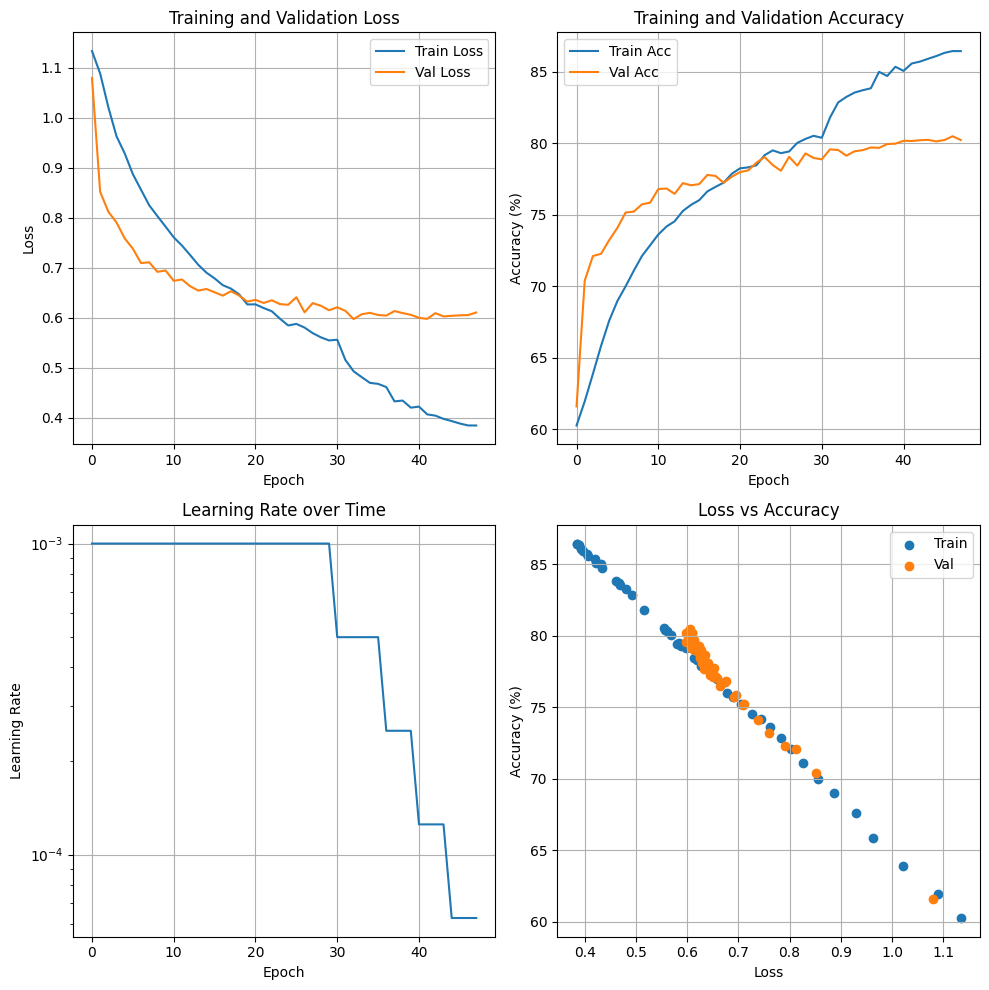

In [20]:
# Plot training history
plot_training_history(history)
plt.show()

In [ ]:
### Improve your model and trainning

In [ ]:
### Use Transfer Learning

### Generating Submission File

In [21]:
X_test = torch.load('X_test.pth')

C:\Users\Neroued\AppData\Local\Temp\ipykernel_32804\3810787237.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test = torch.load('X_test.pth')


In [22]:
X_test.shape

torch.Size([10000, 3, 32, 32])

In [25]:
X_test = torch.load('X_test.pth')
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)  # 扁平化
scaler = StandardScaler()
X_test_scaled_flat = scaler.fit_transform(X_test_reshaped)  # 应用 scaler
X_test_scaled = torch.tensor(X_test_scaled_flat).view_as(X_test)  # 恢复原始形状

C:\Users\Neroued\AppData\Local\Temp\ipykernel_32804\488760647.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test = torch.load('X_test.pth')


In [28]:
X_test_scaled = X_test_scaled.to(device).float()

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_scaled)

In [29]:
_, predicted_labels = torch.max(predictions, dim=1)

In [31]:
submission = pd.DataFrame({
    'index': np.arange(len(X_test)),
    'label': predicted_labels.cpu().numpy()
})

submission.to_csv('submission.csv', index=False, sep=',')
submission.head()

,index,label
0,0,3
1,1,8
2,2,8
3,3,0
4,4,6


In [43]:

X_test_2 = X_test.cpu().numpy()  # 转换为 NumPy 数组

In [44]:
print(X_test_2)

[[[[158. 159. 165. ... 137. 126. 116.]
   [152. 151. 159. ... 136. 125. 119.]
   [151. 151. 158. ... 139. 130. 120.]
   ...
   [ 68.  42.  31. ...  38.  13.  40.]
   [ 61.  49.  35. ...  26.  29.  20.]
   [ 54.  56.  45. ...  24.  34.  21.]]

  [[112. 111. 116. ...  95.  91.  85.]
   [112. 110. 114. ...  95.  91.  88.]
   [110. 109. 111. ...  98.  95.  89.]
   ...
   [124. 100.  88. ...  97.  64.  85.]
   [116. 102.  85. ...  82.  82.  64.]
   [107. 105.  89. ...  77.  84.  67.]]

  [[ 49.  47.  51. ...  36.  36.  33.]
   [ 51.  40.  45. ...  31.  32.  34.]
   [ 47.  33.  36. ...  34.  34.  33.]
   ...
   [177. 148. 137. ... 146. 108. 127.]
   [168. 148. 132. ... 130. 126. 107.]
   [160. 149. 132. ... 124. 129. 110.]]]


 [[[235. 231. 232. ... 233. 233. 232.]
   [238. 235. 235. ... 236. 236. 235.]
   [237. 234. 234. ... 235. 235. 234.]
   ...
   [ 87.  43.  19. ... 169. 182. 188.]
   [ 82.  46.  36. ... 174. 185. 187.]
   [ 85.  62.  58. ... 168. 180. 186.]]

  [[235. 231. 232. ... 233

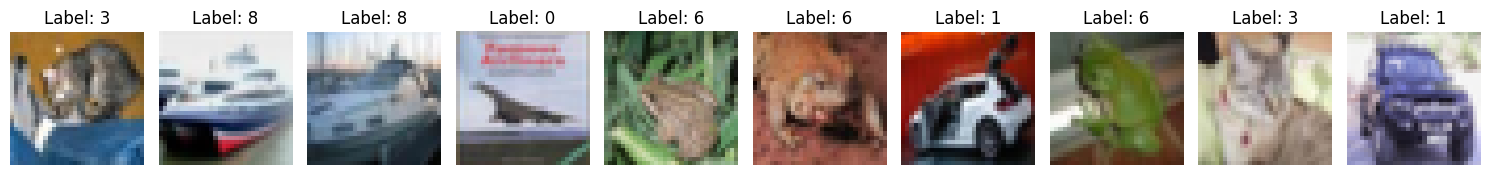

In [45]:
# Plot some examples
fig = plot_images(X_test_2, predicted_labels.cpu().numpy(), num_examples=10)
plt.show()